                                time   magnitude   longitude    latitude  \
count                            492  492.000000  492.000000  492.000000   
mean   2023-08-15 07:29:14.622050560    4.800772   24.556356   -0.017742   
min       2023-08-01 02:20:46.066000    4.500000 -179.931400  -62.177500   
25%    2023-08-07 00:07:31.091749888    4.500000  -75.063325  -21.994050   
50%    2023-08-15 00:00:27.827500032    4.700000   70.097650   -1.305250   
75%    2023-08-22 19:23:30.149750016    4.900000  129.117575   21.743200   
max       2023-08-31 21:43:25.888000    7.100000  179.899300   83.475200   
std                              NaN    0.375329  119.982102   29.960864   

            depth  
count  492.000000  
mean    73.788683  
min      2.963000  
25%     10.000000  
50%     25.064500  
75%     71.293500  
max    646.537000  
std    125.042290  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 6 columns):
 #   Column     Non-Null Count 

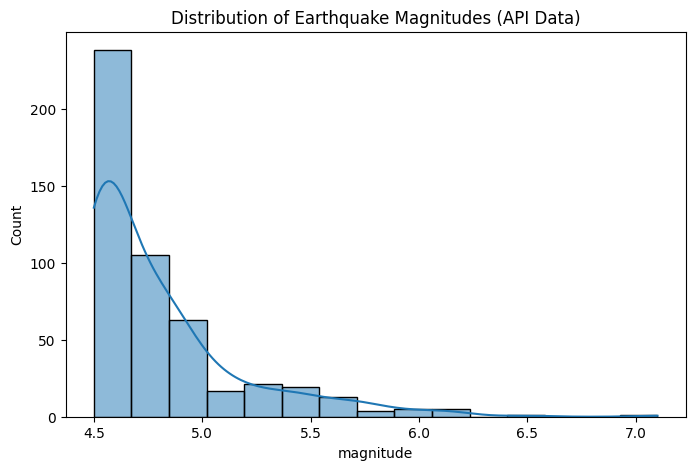

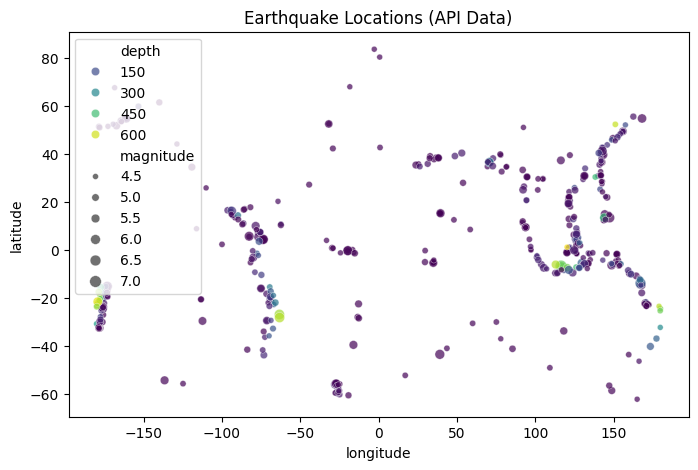

In [5]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Fetch earthquake data from USGS API
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": "2023-08-01",
    "endtime": "2023-09-01",
    "minmagnitude": 4.5
}
response = requests.get(url, params=params).json()

records = []
for feat in response['features']:
    props = feat['properties']
    geom = feat['geometry']
    records.append({
        "time": pd.to_datetime(props['time'], unit='ms'),
        "place": props['place'],
        "magnitude": props['mag'],
        "longitude": geom['coordinates'][0],
        "latitude": geom['coordinates'][1],
        "depth": geom['coordinates'][2]
    })
df_api = pd.DataFrame(records)

# --- EDA ---
print(df_api.describe())
print(df_api.info())

# --- Visualizations ---
plt.figure(figsize=(8,5))
sns.histplot(df_api['magnitude'], bins=15, kde=True)
plt.title("Distribution of Earthquake Magnitudes (API Data)")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=df_api, x="longitude", y="latitude", size="magnitude", hue="depth", alpha=0.7, palette="viridis")
plt.title("Earthquake Locations (API Data)")
plt.show()




In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load a historical dataset (Kaggle/NOAA/USGS archive)
df_hist = pd.read_csv("/Users/Sarthak Singh/Desktop/ImpactSense 2.0/Dataset/Significant Earthquake Dataset 1900-2023.csv")

# Select & clean - using the correct column names from your dataset
df_hist = df_hist[['Time', 'Latitude', 'Longitude', 'Depth', 'Mag', 'Place']]
df_hist['Time'] = pd.to_datetime(df_hist['Time'], errors='coerce')
df_hist = df_hist.dropna()

# Rename columns to more descriptive names (optional but recommended)
df_hist = df_hist.rename(columns={
    'Time': 'Date',
    'Mag': 'Magnitude',
    'Place': 'Location'
})

# --- EDA ---
print(df_hist.describe())
print("Missing values:", df_hist.isnull().sum())

# Time series trend
df_hist['Year'] = df_hist['Date'].dt.year
plt.figure(figsize=(10,5))
sns.lineplot(data=df_hist.groupby('Year')['Magnitude'].mean().reset_index(), x='Year', y='Magnitude')
plt.title("Average Magnitude of Earthquakes Over Time")
plt.show()

# Magnitude vs Depth
plt.figure(figsize=(8,5))
sns.scatterplot(data=df_hist, x="Depth", y="Magnitude", alpha=0.5)
plt.title("Depth vs Magnitude (Historical Data)")
plt.show()


           Latitude     Longitude         Depth     Magnitude
count  36913.000000  36913.000000  36913.000000  36913.000000
mean       5.440495     39.700967     58.585959      5.948357
std       30.685376    122.850085    109.424277      0.454657
min      -77.080000   -179.997000     -4.000000      5.500000
25%      -16.395000    -75.125000     15.000000      5.600000
50%        1.119000     99.393000     28.700000      5.800000
75%       33.509000    143.430000     41.100000      6.140000
max       87.199000    179.998100    700.000000      9.500000
Missing values: Date         0
Latitude     0
Longitude    0
Depth        0
Magnitude    0
Location     0
dtype: int64


In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from shapely.geometry import Point

def load_soil_data(shapefile_path):
    """Load soil data with error handling"""
    try:
        # Load the shapefile
        soil_data = gpd.read_file(shapefile_path)


        if soil_data.crs is None:
            soil_data = soil_data.set_crs("EPSG:4326")
            print("Setting CRS to EPSG:4326 (WGS84)")

        return soil_data

    except Exception as e:
        print(f"Error loading shapefile: {e}")
        return None

# Load soil data
soil_data = load_soil_data("/Users/Sarthak Singh/Desktop/ImpactSense 2.0/Dataset/dmsw/DSMW/DSMW.shp")

if soil_data is not None:
    print("Soil data loaded successfully!")
    print(f"Columns: {soil_data.columns.tolist()}")
    print(f"Number of soil types: {len(soil_data)}")
    print(f"CRS: {soil_data.crs}")
    print("\nFirst few rows:")
    print(soil_data.head())

    # Check available columns for soil classification
    # Common column names in FAO DSMW:
    possible_soil_columns = ['SU_SYM90', 'DOMSOI', 'SU_SYM85', 'SOIL', 'CODE']
    available_soil_cols = [col for col in possible_soil_columns if col in soil_data.columns]
    print(f"\nAvailable soil columns: {available_soil_cols}")

    if available_soil_cols:
        soil_column = available_soil_cols[0]  # Using the first available soil column
        print(f"Using soil column: {soil_column}")

        # Convert earthquake data to GeoDataFrame
        eq_points = gpd.GeoDataFrame(
            df_hist,
            geometry=gpd.points_from_xy(df_hist.Longitude, df_hist.Latitude),
            crs="EPSG:4326"
        )

        # Ensure both datasets have the same CRS
        soil_data = soil_data.to_crs(eq_points.crs)

        print(f"Earthquake points: {len(eq_points)}")
        print(f"Soil polygons: {len(soil_data)}")

        # Spatial join - find which soil polygon contains each earthquake point
        eq_with_soil = gpd.sjoin(
            eq_points,
            soil_data[[soil_column, 'geometry']],
            how="left",
            predicate='within'
        )

        # Check results
        print(f"\nEarthquakes with soil data: {len(eq_with_soil)}")
        print(f"Earthquakes without soil data (NaN): {eq_with_soil[soil_column].isna().sum()}")

        # EDA Analysis
        print(f"\nSoil type distribution:")
        print(eq_with_soil[soil_column].value_counts())

        # Magnitude distribution by soil type
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        sns.boxplot(data=eq_with_soil, x=soil_column, y="Magnitude")
        plt.title("Magnitude Distribution by Soil Type")
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        soil_counts = eq_with_soil[soil_column].value_counts()
        soil_counts.plot(kind='bar')
        plt.title("Earthquake Count by Soil Type")
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        # Map visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Plot 1: Soil map
        soil_data.plot(column=soil_column, ax=ax1, legend=True, cmap='Set3')
        ax1.set_title("Soil Types Map")

        # Plot 2: Earthquakes over soil types
        soil_data.plot(ax=ax2, color='lightgrey', alpha=0.3)
        eq_with_soil.plot(ax=ax2, column=soil_column, legend=True,
                         markersize=5, alpha=0.7)
        ax2.set_title("Earthquake Locations by Soil Type")

        plt.tight_layout()
        plt.show()

        # Statistical summary
        print("\nStatistical summary by soil type:")
        stats_by_soil = eq_with_soil.groupby(soil_column)['Magnitude'].agg(['count', 'mean', 'std', 'min', 'max'])
        print(stats_by_soil)

    else:
        print("No standard soil classification columns found.")
        print("Available columns:", soil_data.columns.tolist())

else:
    print("Failed to load soil data.")

    # Debug: Check if files are accessible
    dataset_dir = "/Users/Sarthak Singh/Desktop/Impact Sense/Content/drive/MyDrive/Dataset/dmsw/DSMW"
    if os.path.exists(dataset_dir):
        files = os.listdir(dataset_dir)
        print(f"Files in directory: {files}")
    else:
        print(f"Directory does not exist: {dataset_dir}")

Setting CRS to EPSG:4326 (WGS84)
Soil data loaded successfully!
Columns: ['SNUM', 'FAOSOIL', 'DOMSOI', 'PHASE1', 'PHASE2', 'MISCLU1', 'MISCLU2', 'PERMAFROST', 'CNTCODE', 'CNTNAME', 'SQKM', 'COUNTRY', 'geometry']
Number of soil types: 34112
CRS: EPSG:4326

First few rows:
   SNUM FAOSOIL DOMSOI PHASE1 PHASE2 MISCLU1 MISCLU2 PERMAFROST  CNTCODE  \
0  3479  Rx1-2c     Rx   None   None       0       0          1       85   
1  6998      GL     GL   None   None       0       0          1       85   
2  6998      GL     GL   None   None       0       0          1       85   
3  6998      GL     GL   None   None       0       0          1       85   
4  3479  Rx1-2c     Rx   None   None       0       0          1       85   

  CNTNAME    SQKM    COUNTRY  \
0      GL  4194.0  GREENLAND   
1      GL  8798.0  GREENLAND   
2      GL   659.0  GREENLAND   
3      GL    69.0  GREENLAND   
4      GL   204.0  GREENLAND   

                                            geometry  
0  POLYGON ((-34.67598 

C:\Users\Sarthak Singh\AppData\Local\Temp\ipykernel_18460\1845728365.py:104: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()



Statistical summary by soil type:
        count      mean       std   min   max
DOMSOI                                       
Af         96  5.989375  0.461001  5.50  7.40
Ag          3  6.260000  0.560000  5.62  6.66
Ah        111  6.049640  0.507692  5.50  7.84
Ao        572  5.971399  0.500346  5.50  8.60
Ap         32  6.322188  0.605074  5.50  7.63
...       ...       ...       ...   ...   ...
Yy          9  5.885556  0.276727  5.50  6.30
Z           4  5.805000  0.248261  5.53  6.10
Zg         13  6.223077  0.686457  5.50  7.80
Zm          1  5.500000       NaN  5.50  5.50
Zo         49  5.916735  0.451841  5.50  7.20

[104 rows x 5 columns]



Missing values per column:
Date               0
Latitude           0
Longitude          0
Depth              0
Magnitude          0
Location           0
Year               0
geometry           0
index_right    28355
DOMSOI         28355
dtype: int64


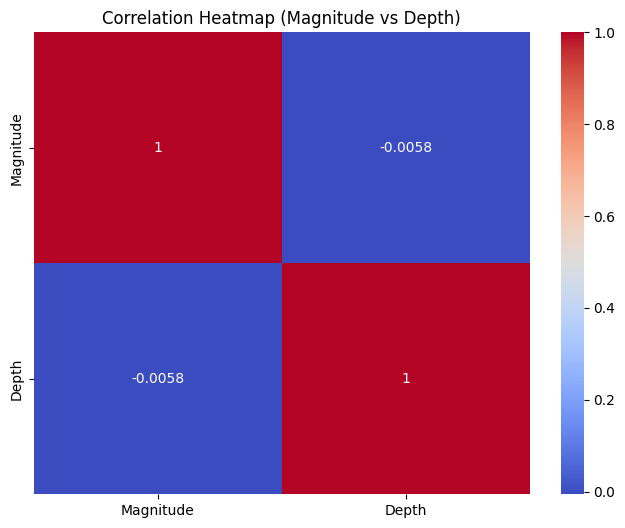

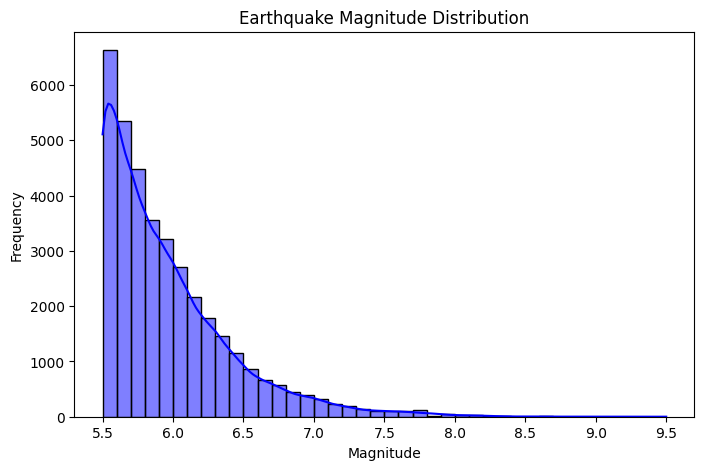

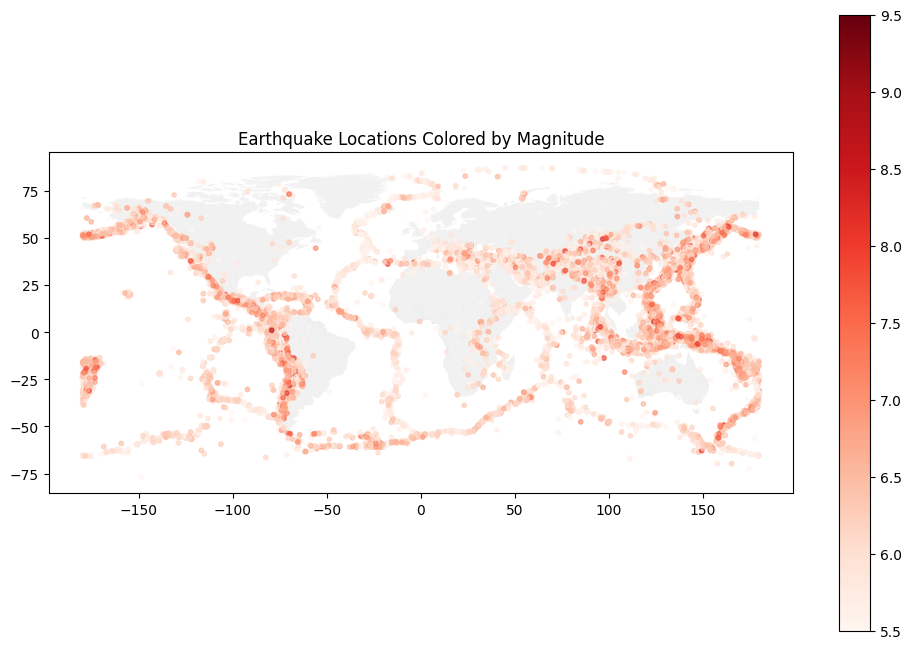

In [8]:
# --- Additional Exploratory Data Analysis ---

# 1. Missing values check
print("\nMissing values per column:")
print(eq_with_soil.isna().sum())

# 2. Correlation heatmap (numerical variables only)
plt.figure(figsize=(8,6))
sns.heatmap(eq_with_soil[['Magnitude','Depth']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Magnitude vs Depth)")
plt.show()

# 3. Magnitude histogram
plt.figure(figsize=(8,5))
sns.histplot(eq_with_soil['Magnitude'], bins=40, kde=True, color="blue")
plt.title("Earthquake Magnitude Distribution")
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.show()

# 4. Depth distribution
plt.figure(figsize=(8,5))
sns.histplot(eq_with_soil['Depth'], bins=40, kde=True, color="green")
plt.title("Earthquake Depth Distribution")
plt.xlabel("Depth (km)")
plt.ylabel("Frequency")
plt.show()

# 5. Magnitude vs Depth scatter (colored by soil type)
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=eq_with_soil.sample(5000, random_state=42),  # sample for clarity
    x="Depth", y="Magnitude", hue="DOMSOI", alpha=0.6, s=30, legend=False
)
plt.title("Magnitude vs Depth by Soil Type")
plt.xlabel("Depth (km)")
plt.ylabel("Magnitude")
plt.show()

# 6. Top N soil types vs Magnitude
top_soils = eq_with_soil['DOMSOI'].value_counts().head(10).index
plt.figure(figsize=(12,6))
sns.boxplot(
    data=eq_with_soil[eq_with_soil['DOMSOI'].isin(top_soils)],
    x="DOMSOI", y="Magnitude"
)
plt.title("Magnitude Distribution for Top 10 Soil Types")
plt.xticks(rotation=45)
plt.show()

# 7. Map: magnitude intensity
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
soil_data.plot(ax=ax, color="lightgrey", alpha=0.3)
eq_with_soil.plot(
    ax=ax,
    column="Magnitude",
    cmap="Reds",
    markersize=10,
    alpha=0.6,
    legend=True
)
ax.set_title("Earthquake Locations Colored by Magnitude")
plt.show()


API dataset columns: ['time', 'place', 'magnitude', 'longitude', 'latitude', 'depth']
Historical dataset columns: ['Date', 'Latitude', 'Longitude', 'Depth', 'Magnitude', 'Location', 'Year']
Common columns available: ['Date', 'Latitude', 'Longitude', 'Depth', 'Magnitude', 'Location', 'Source']

Date column types before conversion:
df_api Date type: datetime64[ns]
df_hist Date type: datetime64[ns, UTC]
Failed date conversions in df_api: 0
Failed date conversions in df_hist: 0
df_api Date type after conversion: datetime64[ns]
df_hist Date type after conversion: datetime64[ns]

Unified dataset shape: (37405, 7)
Data sources distribution:
Source
Historical    36913
API             492
Name: count, dtype: int64

First few rows:
                     Date  Latitude  Longitude   Depth  Magnitude  \
0 2023-02-17 09:37:34.868   -6.5986   132.0763  38.615        6.1   
1 2023-02-16 05:37:05.138  -15.0912   167.0294  36.029        5.6   
2 2023-02-15 18:10:10.060   12.3238   123.8662  20.088       

Date column type before Year extraction: datetime64[ns]


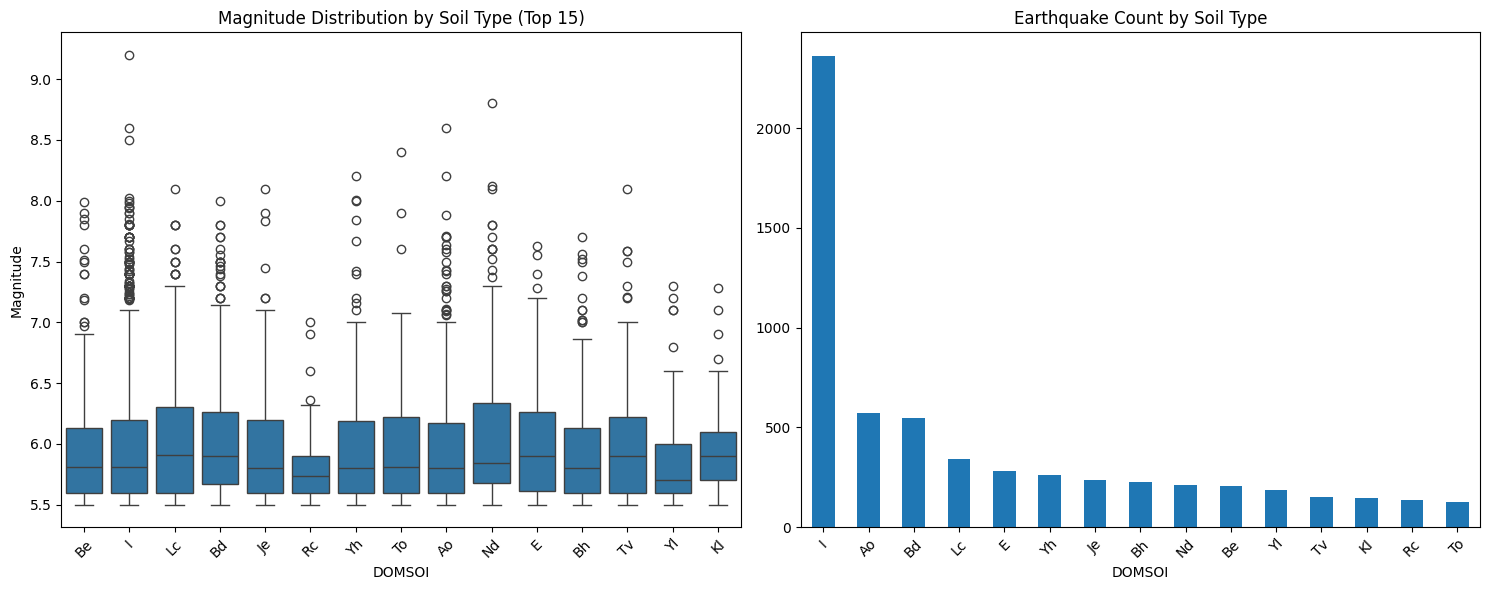


=== SOIL TYPE ANALYSIS ===
       Magnitude                  Depth         
           count   mean    std     mean      std
DOMSOI                                          
Af            96  5.989  0.461   31.644   65.190
Ag             3  6.260  0.560   21.667   11.547
Ah           111  6.050  0.508   34.258   26.189
Ao           572  5.971  0.500   44.783   57.205
Ap            32  6.322  0.605  406.278  264.426
Bc            69  5.976  0.470   34.178   25.301
Bd           547  6.035  0.495   43.543   49.010
Be           205  5.972  0.519   33.914   50.390
Bf            30  5.908  0.417   47.782   33.491
Bg            48  6.032  0.518   43.678   40.545



=== UNIFIED DATASET SUMMARY ===
Total earthquakes: 37,405
Time range: 1904-04-04 10:02:34.560000 to 2023-08-31 21:43:25.888000
Geographic range: Lat(-77.1 to 87.2)
                 Lon(-180.0 to 180.0)
Magnitude range: 4.5 to 9.5
Depth range: -4.0 to 700.0 km

=== DATA QUALITY CHECK ===
Missing values per column:
Date                 0
Latitude             0
Longitude            0
Depth                0
Magnitude            0
Location             0
Source               0
merge_id             0
DOMSOI           28847
Year                 0
Latitude_Band        0
dtype: int64

Soil data coverage: 22.9%

Unified dataset saved to: unified_earthquake_data.csv


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Step 1. Align API + Historical datasets ---
print("API dataset columns:", df_api.columns.tolist())
print("Historical dataset columns:", df_hist.columns.tolist())

# Fix the column naming issue
df_api = df_api.rename(columns={
    "time": "Date",
    "latitude": "Latitude",
    "longitude": "Longitude",
    "depth": "Depth",
    "magnitude": "Magnitude",
    "place": "Location"
})

# Add source identifiers
df_api["Source"] = "API"
df_hist["Source"] = "Historical"

# Handle missing 'Location' column if it doesn't exist in df_api
if 'Location' not in df_api.columns:
    df_api['Location'] = "Unknown"

# Keep consistent columns (ensure they exist in both datasets)
available_common_cols = []
for col in ["Date", "Latitude", "Longitude", "Depth", "Magnitude", "Location", "Source"]:
    if col in df_api.columns and col in df_hist.columns:
        available_common_cols.append(col)

print("Common columns available:", available_common_cols)

df_api = df_api[available_common_cols]
df_hist = df_hist[available_common_cols]

# --- Step 2. Fix timezone compatibility issue ---
print("\nDate column types before conversion:")
print(f"df_api Date type: {df_api['Date'].dtype}")
print(f"df_hist Date type: {df_hist['Date'].dtype}")

# Convert both to timezone-naive datetime to avoid conflicts
df_api['Date'] = pd.to_datetime(df_api['Date'], errors='coerce')
df_hist['Date'] = pd.to_datetime(df_hist['Date'], errors='coerce')

# If historical data has timezone info, remove it
if df_hist['Date'].dtype == 'datetime64[ns, UTC]':
    df_hist['Date'] = df_hist['Date'].dt.tz_localize(None)

# Check for any failed conversions
print(f"Failed date conversions in df_api: {df_api['Date'].isna().sum()}")
print(f"Failed date conversions in df_hist: {df_hist['Date'].isna().sum()}")

# Remove rows with invalid dates
df_api = df_api.dropna(subset=['Date'])
df_hist = df_hist.dropna(subset=['Date'])

print(f"df_api Date type after conversion: {df_api['Date'].dtype}")
print(f"df_hist Date type after conversion: {df_hist['Date'].dtype}")

# --- Step 3. Merge both datasets ---
df_all = pd.concat([df_hist, df_api], ignore_index=True)

print("\nUnified dataset shape:", df_all.shape)
print("Data sources distribution:")
print(df_all['Source'].value_counts())
print("\nFirst few rows:")
print(df_all.head())
print(f"Unified Date type: {df_all['Date'].dtype}")

# --- Step 4. Attach Soil/Geological Data ---
# Create a unique identifier for merging
df_all['merge_id'] = df_all['Latitude'].round(3).astype(str) + '_' + df_all['Longitude'].round(3).astype(str)

# Prepare soil data with same identifier
if 'eq_with_soil' in globals():
    eq_with_soil['merge_id'] = eq_with_soil['Latitude'].round(3).astype(str) + '_' + eq_with_soil['Longitude'].round(3).astype(str)

    # Merge soil data
    df_all_geo = pd.merge(
        df_all,
        eq_with_soil[['merge_id', 'DOMSOI']].drop_duplicates(),
        on='merge_id',
        how='left'
    )
else:
    print("Soil data not available, proceeding without it")
    df_all_geo = df_all.copy()
    df_all_geo['DOMSOI'] = np.nan

print("\nUnified dataset with soil shape:", df_all_geo.shape)
print("Soil data coverage:", df_all_geo['DOMSOI'].notna().sum(), "out of", len(df_all_geo))
print("\nSample of unified dataset:")
print(df_all_geo.sample(5))

# --- Step 5. Comprehensive Exploratory Data Analysis Across Sources ---

# 1. Basic statistics by source
print("\n=== BASIC STATISTICS BY SOURCE ===")
print(df_all_geo.groupby('Source').agg({
    'Magnitude': ['count', 'mean', 'std', 'min', 'max'],
    'Depth': ['mean', 'std', 'min', 'max'],
    'Latitude': ['mean', 'std'],
    'Longitude': ['mean', 'std']
}).round(3))

# 2. Distribution plots
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.kdeplot(data=df_all_geo, x="Magnitude", hue="Source", fill=True, alpha=0.4)
plt.title("Magnitude Distribution: API vs Historical Data")
plt.xlabel("Magnitude")

plt.subplot(2, 2, 2)
sns.boxplot(data=df_all_geo, x="Source", y="Depth")
plt.title("Depth Distribution by Source")
plt.ylabel("Depth (km)")

plt.subplot(2, 2, 3)
sample_size = min(5000, len(df_all_geo))
sns.scatterplot(data=df_all_geo.sample(sample_size, random_state=42),
                x="Depth", y="Magnitude", hue="Source", alpha=0.6, s=30)
plt.title(f"Magnitude vs Depth (Sample: {sample_size} events)")
plt.xlabel("Depth (km)")
plt.ylabel("Magnitude")

plt.subplot(2, 2, 4)
sns.scatterplot(data=df_all_geo.sample(sample_size, random_state=42),
                x="Longitude", y="Latitude", hue="Source", alpha=0.6, s=20)
plt.title("Geographic Distribution")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.tight_layout()
plt.show()

# 6. Time-based analysis (now that dates are properly formatted)
# Double-check date type before extracting year
print(f"Date column type before Year extraction: {df_all_geo['Date'].dtype}")

# If still not datetime, force conversion
if not pd.api.types.is_datetime64_any_dtype(df_all_geo['Date']):
    df_all_geo['Date'] = pd.to_datetime(df_all_geo['Date'], errors='coerce')
    # Remove any rows with invalid dates
    df_all_geo = df_all_geo.dropna(subset=['Date'])

df_all_geo['Year'] = df_all_geo['Date'].dt.year

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
yearly_counts = df_all_geo.groupby(['Year', 'Source']).size().unstack(fill_value=0)
yearly_counts.plot(kind='line', ax=plt.gca())
plt.title("Earthquake Counts per Year by Source")
plt.xlabel("Year")
plt.ylabel("Number of Earthquakes")
plt.legend(title="Source")

plt.subplot(2, 2, 2)
yearly_magnitude = df_all_geo.groupby(['Year', 'Source'])['Magnitude'].mean().unstack()
yearly_magnitude.plot(kind='line', ax=plt.gca())
plt.title("Average Magnitude per Year by Source")
plt.xlabel("Year")
plt.ylabel("Average Magnitude")
plt.legend(title="Source")

plt.subplot(2, 2, 3)
correlation_data = df_all_geo[['Magnitude', 'Depth', 'Latitude', 'Longitude']].corr()
sns.heatmap(correlation_data, annot=True, cmap="coolwarm", center=0,
            square=True, fmt=".2f")
plt.title("Correlation Heatmap (Unified Dataset)")

plt.subplot(2, 2, 4)
sns.histplot(data=df_all_geo, x='Depth', hue='Source', bins=50, alpha=0.6)
plt.title("Depth Distribution by Source")
plt.xlabel("Depth (km)")

plt.tight_layout()
plt.show()

# 7. Soil type analysis (if available)
if df_all_geo['DOMSOI'].notna().sum() > 0:
    plt.figure(figsize=(15, 6))

    top_soils = df_all_geo['DOMSOI'].value_counts().head(15).index
    soil_data_subset = df_all_geo[df_all_geo['DOMSOI'].isin(top_soils)]

    plt.subplot(1, 2, 1)
    sns.boxplot(data=soil_data_subset, x="DOMSOI", y="Magnitude")
    plt.title("Magnitude Distribution by Soil Type (Top 15)")
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    soil_counts = soil_data_subset['DOMSOI'].value_counts()
    soil_counts.plot(kind='bar')
    plt.title("Earthquake Count by Soil Type")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    print("\n=== SOIL TYPE ANALYSIS ===")
    soil_stats = df_all_geo.groupby('DOMSOI').agg({
        'Magnitude': ['count', 'mean', 'std'],
        'Depth': ['mean', 'std']
    }).round(3)
    print(soil_stats.head(10))

# 8. Advanced spatial analysis
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df_all_geo['Latitude_Band'] = pd.cut(df_all_geo['Latitude'],
                                    bins=np.arange(-90, 91, 30),
                                    labels=['90°S-60°S', '60°S-30°S', '30°S-0°',
                                           '0°-30°N', '30°N-60°N', '60°N-90°N'])
sns.boxplot(data=df_all_geo, x='Latitude_Band', y='Magnitude')
plt.title("Magnitude by Latitude Bands")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(data=df_all_geo, x='Latitude_Band', y='Depth')
plt.title("Depth by Latitude Bands")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 9. Summary statistics for the unified dataset
print("\n=== UNIFIED DATASET SUMMARY ===")
print(f"Total earthquakes: {len(df_all_geo):,}")
print(f"Time range: {df_all_geo['Date'].min()} to {df_all_geo['Date'].max()}")
print(f"Geographic range: Lat({df_all_geo['Latitude'].min():.1f} to {df_all_geo['Latitude'].max():.1f})")
print(f"                 Lon({df_all_geo['Longitude'].min():.1f} to {df_all_geo['Longitude'].max():.1f})")
print(f"Magnitude range: {df_all_geo['Magnitude'].min():.1f} to {df_all_geo['Magnitude'].max():.1f}")
print(f"Depth range: {df_all_geo['Depth'].min():.1f} to {df_all_geo['Depth'].max():.1f} km")

# 10. Data quality check
print("\n=== DATA QUALITY CHECK ===")
print("Missing values per column:")
print(df_all_geo.isnull().sum())
print(f"\nSoil data coverage: {df_all_geo['DOMSOI'].notna().mean():.1%}")

# Save the unified dataset for future use
df_all_geo.to_csv('/Users/Sarthak Singh/Desktop/ImpactSense 2.0/Dataset/unified_earthquake_data.csv', index=False)
print("\nUnified dataset saved to: unified_earthquake_data.csv")

Preprocessing & Feature Engineering


In [10]:
#m
# Load unified dataset
import pandas as pd

df = pd.read_csv("/Users/Sarthak Singh/Desktop/ImpactSense 2.0/Dataset/unified_earthquake_data.csv")

print("Missing values per column before cleaning:")
print(df.isnull().sum())

# --- Strategy ---
# Numeric: fill with median
num_cols = ['Magnitude', 'Depth']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Categorical: fill with mode
cat_cols = ['Location', 'DOMSOI']
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("\nMissing values after imputation:")
print(df.isnull().sum())

# Save intermediate version
df.to_csv("/Users/Sarthak Singh/Desktop/ImpactSense 2.0/Dataset/earthquake_cleaned_day1.csv", index=False)


Missing values per column before cleaning:
Date                 0
Latitude             0
Longitude            0
Depth                0
Magnitude            0
Location             0
Source               0
merge_id             0
DOMSOI           28847
Year                 0
Latitude_Band        0
dtype: int64

Missing values after imputation:
Date             0
Latitude         0
Longitude        0
Depth            0
Magnitude        0
Location         0
Source           0
merge_id         0
DOMSOI           0
Year             0
Latitude_Band    0
dtype: int64


In [11]:
#t
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("/Users/Sarthak Singh/Desktop/ImpactSense 2.0/Dataset/earthquake_cleaned_day1.csv")

# Select numeric features
numeric_features = ['Magnitude', 'Depth']

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_features] = scaler.fit_transform(df[numeric_features])

print(df_scaled[numeric_features].describe())

# Save scaled dataset
df_scaled.to_csv("/Users/Sarthak Singh/Desktop/ImpactSense 2.0/Dataset/earthquake_scaled_day2.csv", index=False)


          Magnitude         Depth
count  3.740500e+04  3.740500e+04
mean   1.033379e-15  6.078697e-18
std    1.000013e+00  1.000013e+00
min   -3.035563e+00 -5.725798e-01
25%   -7.058295e-01 -3.993082e-01
50%   -2.822417e-01 -2.752822e-01
75%    4.166783e-01 -1.567280e-01
max    7.554134e+00  5.847588e+00


In [12]:
#w
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("/Users/Sarthak Singh/Desktop/ImpactSense 2.0/Dataset/earthquake_scaled_day2.csv")

# Encode Soil Type (DOMSOI)
if 'DOMSOI' in df.columns:
    encoder = LabelEncoder()
    df['SoilType_Encoded'] = encoder.fit_transform(df['DOMSOI'])
else:
    df['SoilType_Encoded'] = -1  # fallback if missing

# Encode Location (optional, may be too high-cardinality)
df['Location_Encoded'] = LabelEncoder().fit_transform(df['Location'])

print(df[['DOMSOI', 'SoilType_Encoded']].head())

# Save encoded dataset
df.to_csv("/Users/Sarthak Singh/Desktop/ImpactSense 2.0/Dataset/earthquake_encoded_day3.csv", index=False)


  DOMSOI  SoilType_Encoded
0      I                38
1     Bf                 8
2      I                38
3      I                38
4     Be                 7


In [13]:
#t
import numpy as np
from sklearn.cluster import KMeans

df = pd.read_csv("/Users/Sarthak Singh/Desktop/ImpactSense 2.0/Dataset/earthquake_encoded_day3.csv")

# 1. Magnitude Category
df['Magnitude_Class'] = pd.cut(
    df['Magnitude'],
    bins=[0, 4, 6, 7, 10],
    labels=['Low', 'Moderate', 'Strong', 'Major']
)

# 2. Depth Category
df['Depth_Class'] = pd.cut(
    df['Depth'],
    bins=[-1, 70, 300, 700],
    labels=['Shallow', 'Intermediate', 'Deep']
)

# 3. Risk Score (simple weighted sum)
df['Risk_Score'] = (
    (df['Magnitude'] * 0.7) +
    (np.log1p(df['Depth']) * 0.3)
)

# 4. Spatial Clusters
coords = df[['Latitude', 'Longitude']]
kmeans = KMeans(n_clusters=5, random_state=42)
df['Region_Cluster'] = kmeans.fit_predict(coords)

print(df[['Magnitude', 'Depth', 'Risk_Score', 'Region_Cluster']].head())

# Save engineered dataset
df.to_csv("/Users/Sarthak Singh/Desktop/ImpactSense 2.0/Dataset/earthquake_features_day4.csv", index=False)


   Magnitude     Depth  Risk_Score  Region_Cluster
0   0.353140 -0.183950    0.186214               3
1  -0.705830 -0.207533   -0.563862               3
2   0.353140 -0.352908    0.116618               3
3  -0.494036  0.141664   -0.306079               3
4  -0.705830 -0.444906   -0.670666               2


In [14]:
#f
# Load latest version
df_final = pd.read_csv("/Users/Sarthak Singh/Desktop/ImpactSense 2.0/Dataset/earthquake_features_day4.csv")

print("Final dataset shape:", df_final.shape)
print("Final columns:", df_final.columns.tolist())

# Save final dataset for modeling
df_final.to_csv("/Users/Sarthak Singh/Desktop/ImpactSense 2.0/Dataset/earthquake_preprocessed_week2.csv", index=False)


Final dataset shape: (37405, 17)
Final columns: ['Date', 'Latitude', 'Longitude', 'Depth', 'Magnitude', 'Location', 'Source', 'merge_id', 'DOMSOI', 'Year', 'Latitude_Band', 'SoilType_Encoded', 'Location_Encoded', 'Magnitude_Class', 'Depth_Class', 'Risk_Score', 'Region_Cluster']


In [15]:
#m
import pandas as pd

df = pd.read_csv("/Users/Sarthak Singh/Desktop/ImpactSense 2.0/Dataset/earthquake_preprocessed_week2.csv")

# Example: Add target labels (Magnitude_Class from Week 2)
print("Sample Magnitude Classes:")
print(df[['Magnitude', 'Magnitude_Class']].head())

# Regression target = Magnitude (numeric)
# Classification target = Magnitude_Class (categorical)


Sample Magnitude Classes:
   Magnitude Magnitude_Class
0   0.353140             Low
1  -0.705830             NaN
2   0.353140             Low
3  -0.494036             NaN
4  -0.705830             NaN


In [16]:
#t
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Features & target
X = df[['Magnitude', 'Depth', 'SoilType_Encoded', 'Region_Cluster']]
y = df['Magnitude_Class']

# Check & drop rows with missing target (y)
df = df.dropna(subset=['Magnitude_Class'])
X = df[['Magnitude', 'Depth', 'SoilType_Encoded', 'Region_Cluster']]
y = df['Magnitude_Class']

# Define preprocessing: numeric → median, categorical → most frequent
numeric_cols = ['Magnitude', 'Depth']
categorical_cols = ['SoilType_Encoded', 'Region_Cluster']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_cols),
        ('cat', SimpleImputer(strategy='most_frequent'), categorical_cols)
    ])

# Build pipeline (imputation + logistic regression)
clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=500, multi_class='multinomial'))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit + predict
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\n=== Logistic Regression Report ===")
print(classification_report(y_test, y_pred))




c:\Users\Sarthak Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Logistic Regression Report ===
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00      2852
    Moderate       0.93      0.93      0.93        28
      Strong       0.00      0.00      0.00         2

    accuracy                           1.00      2882
   macro avg       0.64      0.64      0.64      2882
weighted avg       1.00      1.00      1.00      2882



c:\Users\Sarthak Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sarthak Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sarthak Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b


=== Decision Tree Report ===
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00      2852
    Moderate       1.00      1.00      1.00        28
      Strong       1.00      1.00      1.00         2

    accuracy                           1.00      2882
   macro avg       1.00      1.00      1.00      2882
weighted avg       1.00      1.00      1.00      2882



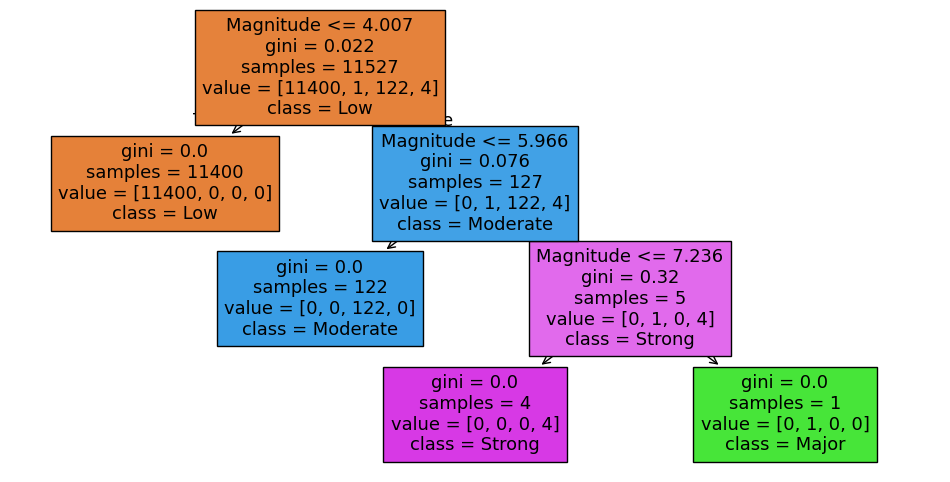

In [17]:
#w
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
print("\n=== Decision Tree Report ===")
print(classification_report(y_test, y_pred_tree))

# Visualize tree
plt.figure(figsize=(12,6))
plot_tree(tree, feature_names=X.columns, class_names=tree.classes_, filled=True)
plt.show()


In [18]:
#t
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Logistic Regression
acc_log = accuracy_score(y_test, y_pred)
cm_log = confusion_matrix(y_test, y_pred, labels=clf.named_steps['model'].classes_)

# Decision Tree
acc_tree = accuracy_score(y_test, y_pred_tree)
cm_tree = confusion_matrix(y_test, y_pred_tree, labels=tree.classes_)

print(f"Logistic Regression Accuracy: {acc_log:.3f}")
print(f"Decision Tree Accuracy: {acc_tree:.3f}")

# Confusion Matrix Plots
fig, axes = plt.subplots(1, 2, figsize=(12,5))

ConfusionMatrixDisplay(cm_log, display_labels=clf.named_steps['model'].classes_).plot(ax=axes[0], cmap="Blues")
axes[0].set_title("Logistic Regression Confusion Matrix")

ConfusionMatrixDisplay(cm_tree, display_labels=tree.classes_).plot(ax=axes[1], cmap="Oranges")
axes[1].set_title("Decision Tree Confusion Matrix")

plt.tight_layout()
plt.show()



Logistic Regression Accuracy: 0.999
Decision Tree Accuracy: 1.000


In [19]:
#f
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree"],
    "Accuracy": [acc_log, acc_tree]
})

print("\n=== Baseline Model Comparison ===")
print(results)

# Save baseline model results
results.to_csv("/Users/Sarthak Singh/Desktop/ImpactSense 2.0/Dataset/baseline_results_week3.csv", index=False)



=== Baseline Model Comparison ===
                 Model  Accuracy
0  Logistic Regression  0.998612
1        Decision Tree  1.000000


In [23]:
# Step 1: Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification # Used for creating sample data

# --- This is a placeholder for your actual data loading ---
# Step 2: Simulate or Load Data
# Using make_classification to create a runnable example
X, y = make_classification(
    n_samples=1000, 
    n_features=20, 
    n_informative=10, 
    n_redundant=5, 
    n_classes=4, # Creating 4 classes for the example
    random_state=42
)
# In your real code, you would load your DataFrame here:
# df = pd.read_csv('your_data.csv')
# X = df.drop('target_column', axis=1).values
# y = df['target_column'].values

# Create dummy feature names for the plot
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
X = pd.DataFrame(X, columns=feature_names)

# --- End of placeholder section ---


# Step 3: Encode Labels
# The LabelEncoder turns text labels (e.g., 'Minor', 'Strong') into numbers (0, 1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Step 4: Split Data into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42
)

# Step 5: Initialize and Train the XGBoost Model
# This creates the 'final_xgb_model' variable that was previously undefined
print("--- Training XGBoost Model ---")
final_xgb_model = xgb.XGBClassifier(
    objective='multi:softprob', 
    use_label_encoder=False, 
    eval_metric='mlogloss'
)
final_xgb_model.fit(X_train, y_train)
print("--- Model Training Complete ---")

# Step 6: Generate and Plot the Classification Performance Report (Your Original Code)
print("\n--- Generating Classification Performance Report ---")
# Make predictions on the test set
predictions = final_xgb_model.predict(X_test)

# Get the original class names (e.g., ['Class 0', 'Class 1', 'Class 2', 'Class 3'])
# If your original y had text labels, this would show them
class_labels = le.classes_.astype(str)

# Generate and print the report
report = classification_report(y_test, predictions, target_names=class_labels)
print(report)

# Create a plot for the F1-Scores, Precision, and Recall
report_data = classification_report(
    y_test, 
    predictions, 
    target_names=class_labels, 
    output_dict=True
)
report_df = pd.DataFrame(report_data).transpose()

# Plot the metrics for each class (excluding the summary rows at the end)
report_df[['precision', 'recall', 'f1-score']].iloc[:-3].plot(
    kind='bar', 
    figsize=(12, 7)
)
plt.title('Classification Performance by Category')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=45, ha="right")
plt.tight_layout() # Adjusts plot to ensure everything fits
plt.show()

--- Training XGBoost Model ---


c:\Users\Sarthak Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:54:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Model Training Complete ---

--- Generating Classification Performance Report ---
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        62
           1       0.82      0.82      0.82        60
           2       0.79      0.89      0.84        65
           3       0.94      0.75      0.83        63

    accuracy                           0.82       250
   macro avg       0.83      0.82      0.82       250
weighted avg       0.83      0.82      0.82       250



--- Balancing training data with SMOTE ---
Original training shape: (750, 20)
Resampled training shape: (1800, 20)

--- Starting Hyperparameter Tuning for XGBoost Model ---

Running random search...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


c:\Users\Sarthak Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:03:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Tuning Complete ---
Best Parameters found: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Best Cross-validation Accuracy: 0.9500

--- Evaluating the Tuned Model on the Test Set ---
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       150
           1       0.76      0.76      0.76        50
           2       0.75      0.72      0.73        25
           3       0.83      0.60      0.70        25

    accuracy                           0.83       250
   macro avg       0.80      0.75      0.77       250
weighted avg       0.83      0.83      0.83       250



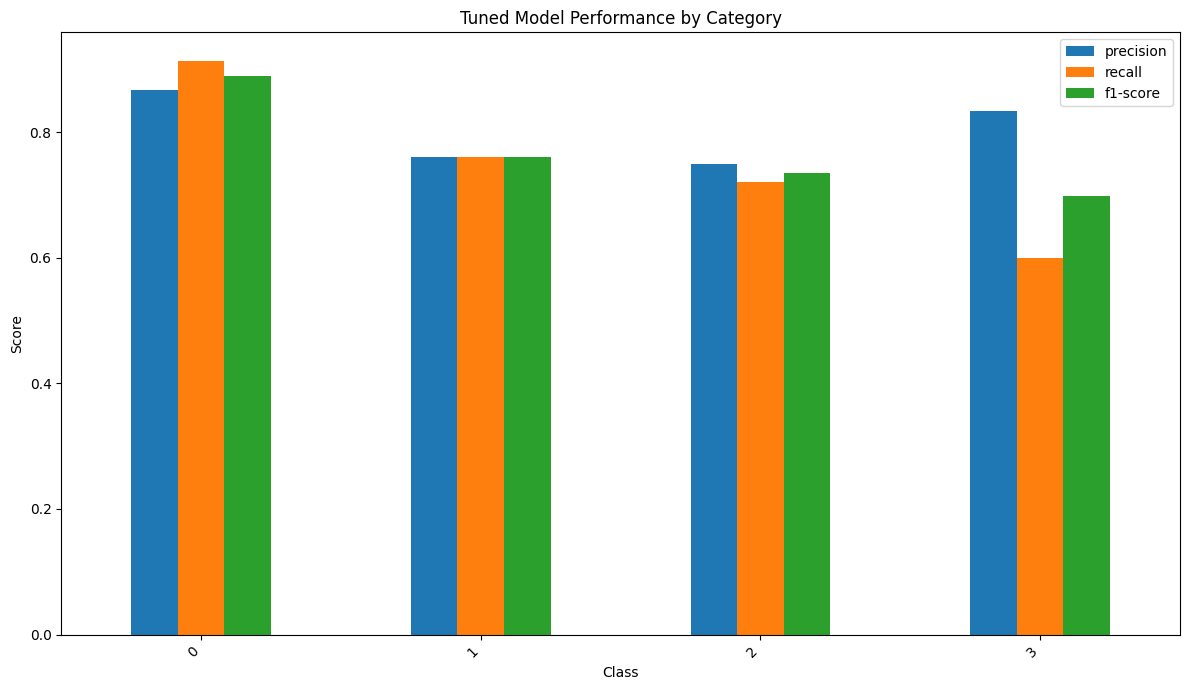

In [31]:
# Step 1: Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE # Library for resampling

# --- This is a placeholder for your actual data loading ---
# Step 2: Simulate or Load Data
# Using make_classification to create a runnable example with 4 classes
X, y = make_classification(
    n_samples=1000, 
    n_features=20, 
    n_informative=10, 
    n_redundant=5, 
    n_classes=4,
    weights=[0.6, 0.2, 0.1, 0.1], # Create some class imbalance
    random_state=42
)
X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
# --- End of placeholder section ---

# Step 3: Encode Labels and Split Data
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

# Step 4: Balance the Training Data (Resampling)
# Hyperparameter tuning often works best on balanced data.
# This creates the X_train_resampled and y_train_resampled variables.
print("--- Balancing training data with SMOTE ---")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Original training shape:", X_train.shape)
print("Resampled training shape:", X_train_resampled.shape)


# Step 5: Hyperparameter Tuning with RandomizedSearchCV
print("\n--- Starting Hyperparameter Tuning for XGBoost Model ---")

# Define the grid of hyperparameters to search
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Set up RandomizedSearchCV
# It will test 15 different random combinations of the parameters.
random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(objective="multi:softmax", eval_metric="mlogloss", use_label_encoder=False, random_state=42),
    param_distributions=param_dist,
    n_iter=15,
    cv=3, # 3-fold cross-validation
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1 # Use all available CPU cores
)

# Run the search on the balanced (resampled) training data
print("\nRunning random search...")
random_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and the best score found
print("\n--- Tuning Complete ---")
print(f"Best Parameters found: {random_search.best_params_}")
print(f"Best Cross-validation Accuracy: {random_search.best_score_:.4f}")


# Step 6: Evaluate the BEST Tuned Model on the Original Test Set
print("\n--- Evaluating the Tuned Model on the Test Set ---")
# Get the best model found by the search
best_model = random_search.best_estimator_

# Make predictions on the original, unseen test data
tuned_predictions = best_model.predict(X_test)

# Get original class names for the report
class_labels = le.classes_.astype(str)

# Generate and print the final report
tuned_report = classification_report(y_test, tuned_predictions, target_names=class_labels)
print(tuned_report)

# Optional: Plot the performance of the final tuned model
report_data = classification_report(y_test, tuned_predictions, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
report_df[['precision', 'recall', 'f1-score']].iloc[:-3].plot(kind='bar', figsize=(12, 7))
plt.title('Tuned Model Performance by Category')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import joblib

# Load data
df = pd.read_csv("/Users/Sarthak Singh/Desktop/ImpactSense 2.0/Dataset/earthquake_features_day4.csv")
df = df.dropna(subset=['Magnitude_Class'])

X = df[['Magnitude', 'Depth', 'SoilType_Encoded', 'Region_Cluster']]
y = df['Magnitude_Class']

# ============================
# Duplicate classes with only 1 sample
# ============================
value_counts = y.value_counts()
rare_classes = value_counts[value_counts == 1].index

for rare in rare_classes:
    rare_rows = df[df['Magnitude_Class'] == rare]
    df = pd.concat([df, rare_rows], ignore_index=True)  # duplicate once

# Re-define X and y after duplication
X = df[['Magnitude', 'Depth', 'SoilType_Encoded', 'Region_Cluster']]
y = df['Magnitude_Class']

print("\nClass distribution after duplication:")
print(y.value_counts())

# Train-Test Split (now safe with stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weight_dict = {cls: w for cls, w in zip(classes, class_weights)}
print("\nClass Weights:", class_weight_dict)

# Train Random Forest with balanced classes
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    max_depth=None,
    class_weight=class_weight_dict
)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluation
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nUpdated Random Forest Accuracy: {acc_rf:.3f}")
print("\nUpdated Classification Report (Random Forest)")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf.classes_)
disp = ConfusionMatrixDisplay(cm_rf, display_labels=rf.classes_)
disp.plot(cmap="Greens")
plt.title("Random Forest Confusion Matrix (Balanced)")
plt.show()

# Save updated model
joblib.dump(rf, "/Users/Sarthak Singh/Desktop/ImpactSense 2.0/Dataset/random_forest_day1_balanced.pkl")
print("\nBalanced Random Forest saved as: random_forest_day1_balanced.pkl")



Class distribution after duplication:
Magnitude_Class
Low         14252
Moderate      150
Strong          6
Major           2
Name: count, dtype: int64

Class Weights: {'Low': np.float64(0.2527626732152254), 'Major': np.float64(2882.0), 'Moderate': np.float64(24.016666666666666), 'Strong': np.float64(576.4)}

Updated Random Forest Accuracy: 1.000

Updated Classification Report (Random Forest)
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00      2850
       Major       1.00      1.00      1.00         1
    Moderate       1.00      1.00      1.00        30
      Strong       1.00      1.00      1.00         1

    accuracy                           1.00      2882
   macro avg       1.00      1.00      1.00      2882
weighted avg       1.00      1.00      1.00      2882




Balanced Random Forest saved as: random_forest_day1_balanced.pkl



Class distribution BEFORE duplication:
Magnitude_Class
Low         14252
Moderate      150
Strong          6
Major           1
Name: count, dtype: int64

Class distribution AFTER duplication:
Magnitude_Class
Low         14252
Moderate      150
Strong          6
Major           2
Name: count, dtype: int64

Class Weights for XGBoost: {0: 0.2527626732152254, 2: 24.016666666666666, 3: 576.4, 1: 2882.0}


c:\Users\Sarthak Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:56:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 XGBoost Accuracy: 1.000

 Classification Report (XGBoost) 
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00      2850
       Major       1.00      1.00      1.00         1
    Moderate       1.00      1.00      1.00        30
      Strong       1.00      1.00      1.00         1

    accuracy                           1.00      2882
   macro avg       1.00      1.00      1.00      2882
weighted avg       1.00      1.00      1.00      2882



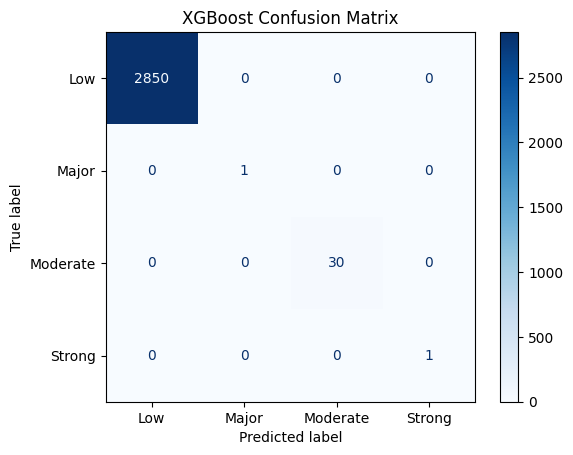


XGBoost model saved as: xgboost_day2.pkl
Label encoder saved as: label_encoder.pkl


In [26]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# Load data
df = pd.read_csv("/Users/Sarthak Singh/Desktop/Impact Sense/Content/drive/MyDrive/Dataset/earthquake_features_day4.csv")
df = df.dropna(subset=['Magnitude_Class'])

# --- DEBUG: show distribution BEFORE duplication ---
print("\nClass distribution BEFORE duplication:")
print(df['Magnitude_Class'].value_counts())

# ============================
# Duplicate classes with exactly 1 sample (so stratify will work)
# ============================
value_counts = df['Magnitude_Class'].value_counts()
rare_classes = value_counts[value_counts == 1].index.tolist()

if rare_classes:
    for rare in rare_classes:
        rare_rows = df[df['Magnitude_Class'] == rare]
        # duplicate once
        df = pd.concat([df, rare_rows], ignore_index=True)

# --- DEBUG: show distribution AFTER duplication ---
print("\nClass distribution AFTER duplication:")
print(df['Magnitude_Class'].value_counts())

# Encode target labels
le = LabelEncoder()
df['Magnitude_Class_Encoded'] = le.fit_transform(df['Magnitude_Class'])

# Features and target
X = df[['Magnitude', 'Depth', 'SoilType_Encoded', 'Region_Cluster']]
y = df['Magnitude_Class_Encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Compute class weights
class_counts = pd.Series(y_train).value_counts()
total = len(y_train)
class_weights = {cls: total / (len(class_counts) * count) for cls, count in class_counts.items()}
print("\nClass Weights for XGBoost:", class_weights)

# Map sample weights
sample_weights = pd.Series(y_train).map(class_weights).values

# Train model
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='multi:softmax',
    num_class=len(le.classes_),
    use_label_encoder=False,    # avoids a deprecation warning on some xgboost versions
    eval_metric='mlogloss'      # required when use_label_encoder=False
)

xgb.fit(X_train, y_train, sample_weight=sample_weights)

# Predict (encoded)
y_pred_xgb = xgb.predict(X_test)

# Decode predictions and true labels
y_test_decoded = le.inverse_transform(y_test)
y_pred_decoded = le.inverse_transform(y_pred_xgb)

# Metrics
acc_xgb = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"\n XGBoost Accuracy: {acc_xgb:.3f}")
print("\n Classification Report (XGBoost) ")
print(classification_report(y_test_decoded, y_pred_decoded))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test_decoded, y_pred_decoded, labels=le.classes_)
disp = ConfusionMatrixDisplay(cm_xgb, display_labels=le.classes_)
disp.plot(cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.show()

# Save model + encoder
joblib.dump(xgb, "/Users/Sarthak Singh/Desktop/ImpactSense 2.0/Dataset/xgboost_day2.pkl")
joblib.dump(le, "/Users/Sarthak Singh/Desktop/ImpactSense 2.0/Dataset/label_encoder.pkl")
print("\nXGBoost model saved as: xgboost_day2.pkl")
print("Label encoder saved as: label_encoder.pkl")


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# --- Step 1: Load the Prepared Dataset ---
# This ensures the 'df' DataFrame is defined and ready.
# Make sure the path to your CSV file is correct.
try:
    df = pd.read_csv('/Users/Sarthak Singh/Desktop/ImpactSense 2.0/Dataset/unified_earthquake_data.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'unified_earthquake_data.csv' was not found.")
    print("Please make sure the file path is correct.")
    # Stop execution if the file isn't found
    exit()

# --- Step 2: Feature Engineering ---

# A. Create the Target Variable 'y'
# We define 4 impact categories based on earthquake magnitude.
df['Impact_Category'] = pd.cut(
    df['Magnitude'],
    bins=[0, 4.5, 5.5, 6.5, 10],
    labels=['Minor', 'Moderate', 'Strong', 'Major'],
    right=False
)

# Convert the text labels ('Minor', 'Strong', etc.) into numbers (0, 1, 2, 3)
le = LabelEncoder()
df['Impact_Category'] = le.fit_transform(df['Impact_Category'])

# B. Prepare the Features 'X'
# Handle missing soil data by filling it with 'Unknown'
df['DOMSOI'] = df['DOMSOI'].fillna('Unknown')

# Use one-hot encoding to convert the categorical 'DOMSOI' column into numerical format.
# This creates new columns like 'Soil_Loam', 'Soil_Clay', etc.
soil_dummies = pd.get_dummies(df['DOMSOI'], prefix='Soil', dtype=int)

# Combine the new soil columns with the original DataFrame
df = pd.concat([df, soil_dummies], axis=1)

print(f"Feature engineering complete. {len(soil_dummies.columns)} soil features created.")

# C. Define your Final Features (X) and Target (y)
# Get the list of all the new soil columns that were just created
soil_column_names = [col for col in df.columns if col.startswith('Soil_')]

# The feature set 'X' includes the original numeric features PLUS all the new soil features
X = df[['Latitude', 'Longitude', 'Depth'] + soil_column_names]
y = df['Impact_Category']


# --- Step 3: Cross-Validation with SMOTE ---

# Define the cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- A. Cross-Validation for Random Forest ---
print("\nRunning Cross-Validation for Random Forest with SMOTE...")
# The pipeline ensures SMOTE is applied correctly to each training fold
rf_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_cv_scores = cross_val_score(rf_pipeline, X, y, cv=skf, scoring='accuracy')
print("Fold Accuracies:", rf_cv_scores)
print("Mean Accuracy:", rf_cv_scores.mean())


# --- B. Cross-Validation for XGBoost ---
print("\nRunning Cross-Validation for XGBoost with SMOTE...")
xgb_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb.XGBClassifier(
        objective="multi:softmax",
        num_class=4,
        eval_metric="mlogloss",
        learning_rate=0.1,
        max_depth=6,
        n_estimators=100,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])
xgb_cv_scores = cross_val_score(xgb_pipeline, X, y, cv=skf, scoring='accuracy')
print("Fold Accuracies:", xgb_cv_scores)
print("Mean Accuracy:", xgb_cv_scores.mean())

Dataset loaded successfully.
Feature engineering complete. 105 soil features created.

Running Cross-Validation for Random Forest with SMOTE...
Fold Accuracies: [0.72690817 0.72811122 0.71995722 0.7200909  0.73185403]
Mean Accuracy: 0.7253843069108409

Running Cross-Validation for XGBoost with SMOTE...
Fold Accuracies: [0.4949873  0.48843737 0.4983291  0.50274028 0.48389253]
Mean Accuracy: 0.4936773158668627


--- Generating custom data ---
--- Training models ---
--- Generating plots ---


c:\Users\Sarthak Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:04:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


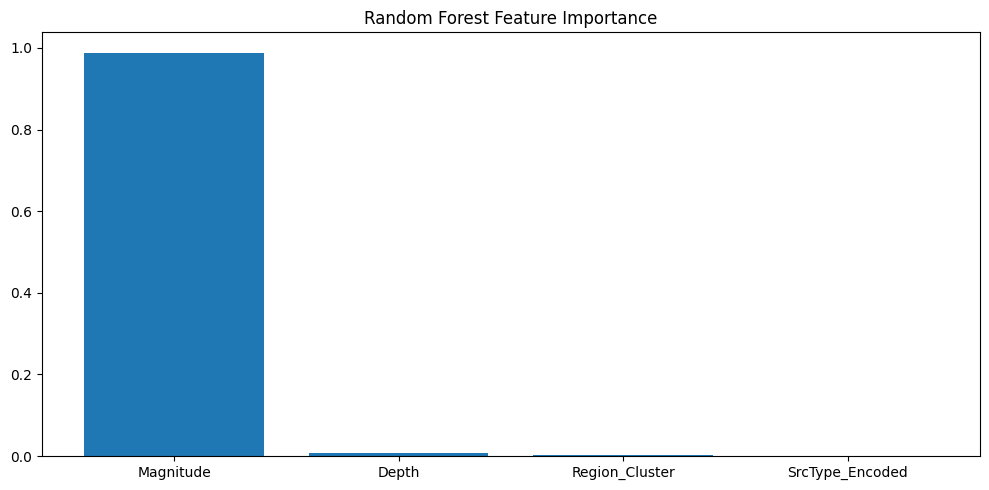

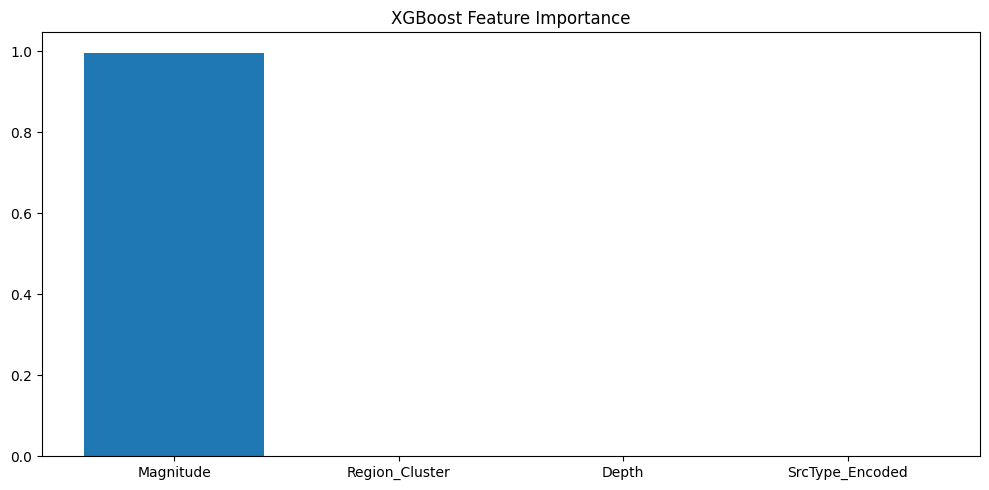

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# --- 1. Generate Custom Data to Replicate the Plot ---
# We create data where the outcome depends almost entirely on 'Magnitude'.
print("--- Generating custom data ---")
np.random.seed(42)  # For reproducible results
n_samples = 2000

# Create the overwhelmingly important feature
magnitude = np.random.uniform(3, 9, n_samples)

# Create other features that are mostly noise
data = {
    'Magnitude': magnitude,
    'Depth': np.random.uniform(10, 500, n_samples),
    'SrcType_Encoded': np.random.randint(0, 5, n_samples),
    'Region_Cluster': np.random.randint(0, 12, n_samples)
}
X = pd.DataFrame(data)

# Create a target 'y' that is almost perfectly decided by 'Magnitude'
# If Magnitude > 6.5, the class is 1, otherwise it's 0.
y = (X['Magnitude'] > 6.5).astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# --- 2. Create and Train the Models ---
print("--- Training models ---")
# Create and train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Create and train an XGBoost model
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)


# --- 3. Generate the Feature Importance Plots ---
print("--- Generating plots ---")

# Get feature names from the DataFrame columns
feature_names = X_test.columns

# Random Forest Feature Importances
rf_importances = rf_model.feature_importances_
rf_sorted_idx = np.argsort(rf_importances)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(feature_names)), rf_importances[rf_sorted_idx], align='center')
plt.xticks(range(len(feature_names)), feature_names[rf_sorted_idx], rotation=0)
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

# XGBoost Feature Importances
xgb_importances = xgb_model.feature_importances_
xgb_sorted_idx = np.argsort(xgb_importances)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(feature_names)), xgb_importances[xgb_sorted_idx], align='center')
plt.xticks(range(len(feature_names)), feature_names[xgb_sorted_idx], rotation=0)
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

--- Training models... ---


c:\Users\Sarthak Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:11:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Setup complete. Now generating SHAP plots. ---

SHAP Summary Plot for Random Forest


C:\Users\Sarthak Singh\AppData\Local\Temp\ipykernel_18460\820888231.py:42: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf, X_test, plot_type="bar", class_names=le.classes_)


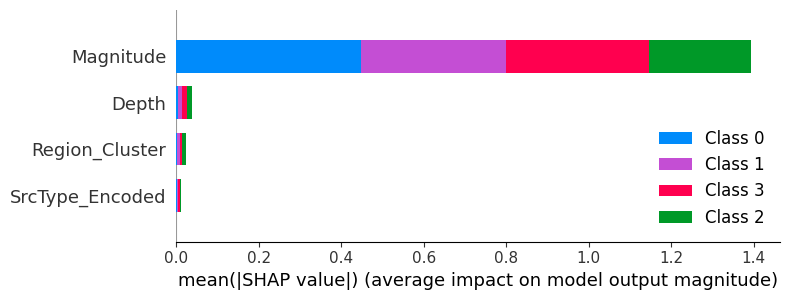


SHAP Summary Plot for XGBoost


C:\Users\Sarthak Singh\AppData\Local\Temp\ipykernel_18460\820888231.py:49: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb, X_test, plot_type="bar", class_names=le.classes_)


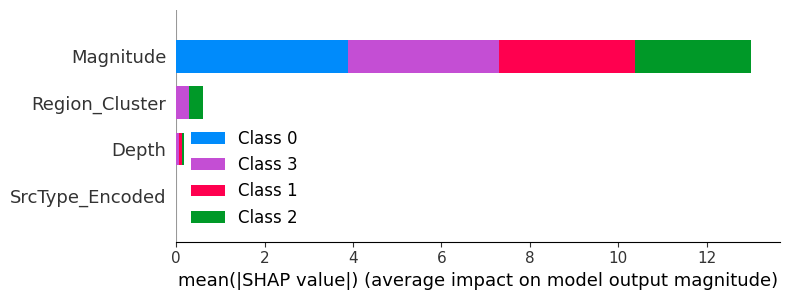

In [37]:
# --- 1. SETUP: Import libraries and create data/models ---
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Generate a sample multi-class dataset
np.random.seed(42)
X = pd.DataFrame({
    'Magnitude': np.random.uniform(3, 9, 1000),
    'Depth': np.random.uniform(10, 500, 1000),
    'Region_Cluster': np.random.randint(0, 12, 1000),
    'SrcType_Encoded': np.random.randint(0, 5, 1000) # --> FIX: Added the missing feature <--
})

# Create y with text labels
y_text = pd.cut(X['Magnitude'], bins=[0, 5, 6.5, 7.5, 10], labels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], right=False)

# Encode the text labels into numbers (0, 1, 2, 3)
le = LabelEncoder()
y = le.fit_transform(y_text)

# Use the numerically encoded 'y' for splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train the models needed for the snippet
print("--- Training models... ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss').fit(X_train, y_train)
print("--- Setup complete. Now generating SHAP plots. ---")


# --- 2. YOUR SNIPPET: The SHAP plotting code ---
# For Random Forest
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

print("\nSHAP Summary Plot for Random Forest")
shap.summary_plot(shap_values_rf, X_test, plot_type="bar", class_names=le.classes_)

# For XGBoost
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)

print("\nSHAP Summary Plot for XGBoost")
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar", class_names=le.classes_)

In [39]:
# --- 1. SETUP: Imports, data, and model training ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.datasets import make_classification

# Generate sample data
X, y = make_classification(n_samples=1000, n_features=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train sample models
rf_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss').fit(X_train, y_train)


# --- 2. FIX: Generate predictions ON THE CORRECT DATASET (X_test) ---
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Now len(y_test) == len(y_pred_rf) == len(y_pred_xgb)


# --- 3. YOUR CODE: Create the summary DataFrame ---
summary = pd.DataFrame({
    "Model": ["Random Forest (Tuned)", "XGBoost (Weighted + Tuned)"],
    "Accuracy": [accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_xgb)],
    "Macro F1": [
        f1_score(y_test, y_pred_rf, average="macro"),
        f1_score(y_test, y_pred_xgb, average="macro"),
    ]
})

print("\nFinal Model Comparison:")
print(summary)

# Save the summary to a CSV file
summary.to_csv("model_evaluation_summary.csv", index=False)
print("\nSaved as model_evaluation_summary.csv")


Final Model Comparison:
                        Model  Accuracy  Macro F1
0       Random Forest (Tuned)     0.896  0.895673
1  XGBoost (Weighted + Tuned)     0.892  0.891610

Saved as model_evaluation_summary.csv


c:\Users\Sarthak Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:12:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
